In [1]:
from show import show_images
from objectDetector import ObjectDetector
from textDetector import TextDetector
from textReader import TextReader

from PIL.Image import Image
import unicodedata
import numpy as np
import torch
import time

c:\Users\jjkha\anaconda3\envs\ocr\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

In [3]:
od = ObjectDetector()
td = TextDetector()
tr = TextReader()

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [4]:
def get_title(cropped_img):
    tb_list, rt_tb_list = td.crop_all(cropped_img)

    # 원본 이미지
    text_box_list, td_prob_list, _etc_box, _etc_probs = tb_list
    title_text_list, tr_prob_list = tr.get_title(text_box_list)
    title_text = " ".join(title_text_list)
    original_set = [title_text, np.mean(td_prob_list), np.mean(tr_prob_list)]

    # 회전한 이미지
    rt_text_box_list, rt_td_prob_list, _rt_etc_box, _rt_etc_probs = rt_tb_list
    rt_title_text_list, rt_tr_prob_list = tr.get_title(rt_text_box_list)
    rt_title_text = " ".join(rt_title_text_list)
    rotated_set = [rt_title_text, np.mean(rt_td_prob_list), np.mean(rt_tr_prob_list)]

    # 결과 확인
    res = sorted([original_set, rotated_set], key=lambda x: (x[2], x[1]), reverse=True)
    print(res)
    return res[0][0]

In [9]:
image_path = r"D:\\python_project\\OCR\\image\\KakaoTalk_20240924_121013522.jpg"

In [10]:
cropped_img_list = od.get_object_images(image_path)


image 1/1 D:\python_project\OCR\image\KakaoTalk_20240924_121013522.jpg: 640x480 18 books, 201.6ms
Speed: 5.5ms preprocess, 201.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


In [11]:
results = []
title_list = []

for img in cropped_img_list:
    st_time = time.time()

    # 텍스트 영역 탐지
    tb_list, rt_tb_list = td.crop_all(img)
    # 시간 측정
    td_time = time.time()
    print(f"Text Detect: {td_time-st_time}")

    # 원본 이미지
    text_box_list, td_prob_list, _etc_box, _etc_probs = tb_list
    title_text_list, tr_prob_list = tr.get_title(text_box_list)
    title_text = " ".join(title_text_list)
    original_set = [title_text, np.mean(td_prob_list), np.mean(tr_prob_list)]
    # 시간 측정
    tr_time = time.time()
    print(f"Text Read: {tr_time-td_time}, {len(text_box_list)}")

    # 회전한 이미지
    rt_text_box_list, rt_td_prob_list, _rt_etc_box, _rt_etc_probs = rt_tb_list
    rt_title_text_list, rt_tr_prob_list = tr.get_title(rt_text_box_list)
    rt_title_text = " ".join(rt_title_text_list)
    rotated_set = [rt_title_text, np.mean(rt_td_prob_list), np.mean(rt_tr_prob_list)]
    # 시간 측정
    rt_time = time.time()
    print(f"Rotation Read: {rt_time-tr_time}, {len(rt_text_box_list)}")

    # 결과 확인
    res = sorted([original_set, rotated_set], key=lambda x: (x[2], x[1]), reverse=True)
    # 시간 측정
    res_time = time.time()
    print(f"Choice Read: {res_time-rt_time}")

    print(res)
    results.append(res)
    title_list.append(res[0][0])
    print()

Text Detect: 21.502002716064453
Text Read: 2.6342601776123047, 1
Rotation Read: 3.5207982063293457, 1
Choice Read: 0.0
[['< 공및및긋', np.float64(0.0008096484816633165), np.float64(0.4969894289970398)], ['입관리', np.float64(0.3093048327721739), np.float64(0.44577938318252563)]]

Text Detect: 28.34121322631836
Text Read: 4.404576539993286, 2
Rotation Read: 3.9539222717285156, 2
Choice Read: 0.0
[['성경 전서', np.float64(0.9996760040278403), np.float64(0.9623790979385376)], ['To ', np.float64(0.3095528654862235), np.float64(0.5693717300891876)]]

Text Detect: 16.66658854484558
Text Read: 5.388607978820801, 2
Rotation Read: 5.772334098815918, 2
Choice Read: 0.0
[['협매계획20. for R임피 R이일 혀시필', np.float64(0.05552183021758914), np.float64(0.5551523566246033)], ['정물지영을 있일십당', np.float64(0.005830185173936309), np.float64(0.5280304700136185)]]

Text Detect: 9.22594404220581
Text Read: 2.519308567047119, 1
Rotation Read: 3.0528595447540283, 1
Choice Read: 0.0
[['관립상세핵관', np.float64(0.16940618250724124), np.f

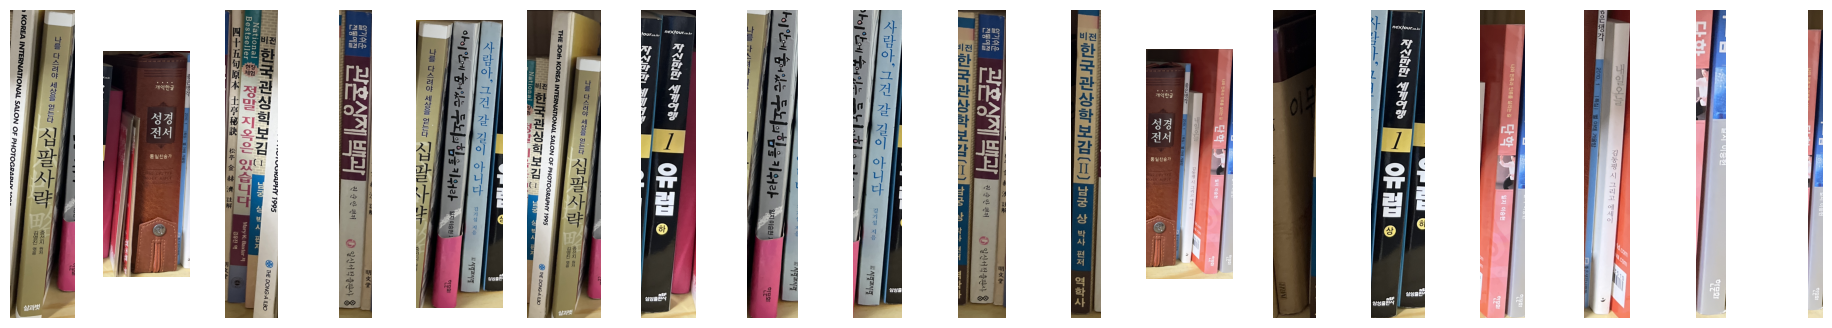

In [12]:
show_images(cropped_img_list)

In [10]:
with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(get_title, cropped_img_list), total=len(cropped_img_list))) 

100%|██████████| 9/9 [01:50<00:00, 12.26s/it]


In [18]:
with ThreadPoolExecutor() as executor:
    results = list(executor.map(get_title, cropped_img_list))

In [16]:
results

['재즈의 계절',
 '리추열',
 '세상 바보 웃연시 화내는 방법',
 '남극으로 걸어간 산책자',
 '미식견문록',
 '사랑의기술',
 '몬신부로쾨의 우아하게가난해지는법',
 '다정한 무관심',
 '빅더 프랭클의 죽음의 수용소에서']

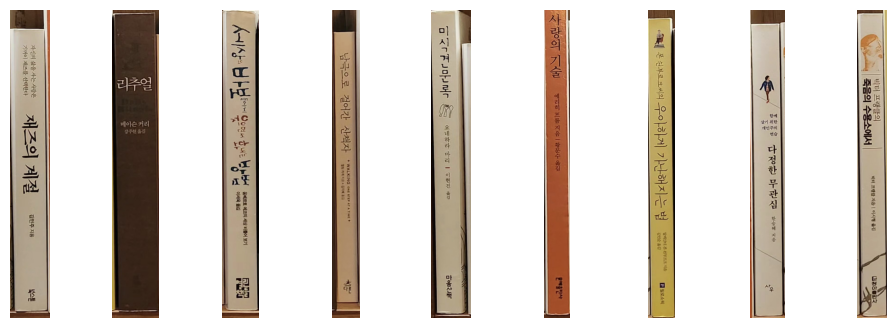

In [6]:
show_images(cropped_img_list)

In [ ]:
results = []
title_list = []
for img in cropped_img_list:
    tb_list, rt_tb_list = td.crop_all(img)

    # 원본 이미지
    text_box_list, td_prob_list, _etc_box, _etc_probs = tb_list
    title_text_list, tr_prob_list = tr.get_title(text_box_list)
    title_text = " ".join(title_text_list)
    original_set = [title_text, np.mean(td_prob_list), np.mean(tr_prob_list)]

    # 회전한 이미지
    rt_text_box_list, rt_td_prob_list, _rt_etc_box, _rt_etc_probs = rt_tb_list
    rt_title_text_list, rt_tr_prob_list = tr.get_title(rt_text_box_list)
    rt_title_text = " ".join(rt_title_text_list)
    rotated_set = [rt_title_text, np.mean(rt_td_prob_list), np.mean(rt_tr_prob_list)]

    # 결과 확인
    res = sorted([original_set, rotated_set], key=lambda x: (x[2], x[1]), reverse=True)
    print(res)
    results.append(res)
    title_list.append(res[0][0])